# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'July/August 2023'

## Setup

In [2]:
# Are we running in Google Colab, or not?
try:
    from google.colab import drive
    COLAB = True
except:
    COLAB = False

if COLAB:
    # Establish Google Drive connection
    drive.mount('/content/drive', force_remount = True)

    # Establish working directory
    %cd '/content/drive/My Drive/599_team_project/deliverables'

Mounted at /content/drive
/content/drive/My Drive/599_team_project/deliverables


In [3]:
if COLAB:
    # Install known missing libraries in Colab
    !pip install transformers
    !pip install openai  # ultimately not used here
    !pip install langchain  # ultimately not used here
    !pip install pinecone-client  # ultimately not used here

# Import basic and data access libraries
import numpy as np
import pandas as pd
import random

# Import base model and evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Import transfomer, LLM libraries and support
import transformers
from transformers import logging as hf_logging
import torch

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import gaussian_kde

# Import utility libraries
from tqdm import tqdm; tqdm.pandas()
import warnings
import time
import logging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 18.5 MB/s eta 0:00:00


In [4]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

In [5]:
# Establish GPU support "if" exists
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(device)

cuda


In [6]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='bitsandbytes')

## Data Load and Validation

In [7]:
# Instantiate and confirm master dataframe
news_00_df = pd.read_csv('../data/data_preprocessed_w_sw_2023-07-20_13-02-01408354.csv')

# Load pre-processed sentiment
news_04_df = pd.read_csv('../data/news-04.csv')
news_04_df = pd.merge(news_00_df, news_04_df, on='text_id')

# Load pre-processed embeddings as numpy array
embeddings = np.load('../data/embeddings.npy', allow_pickle=True)
news_04_df['embeddings'] = list(embeddings)

# Load PerSenT training data
train_00_df = pd.read_csv('../data/train.csv')

print(news_04_df.info())
print(train_00_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36405 entries, 0 to 36404
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text_id                   36405 non-null  int64  
 1   source_name               36405 non-null  object 
 2   author                    36196 non-null  object 
 3   title                     36405 non-null  object 
 4   url                       36405 non-null  object 
 5   publish_date              36405 non-null  object 
 6   article_text              36405 non-null  object 
 7   content                   36405 non-null  object 
 8   processed_text            36403 non-null  object 
 9   processed_text_split      36405 non-null  object 
 10  num_tokens                36405 non-null  int64  
 11  sentiment_vader           36405 non-null  object 
 12  sentiment_vader_compound  36405 non-null  float64
 13  sentiment_vader_cat       36405 non-null  object 
 14  sentim

## Sentiment Analysis: EDA

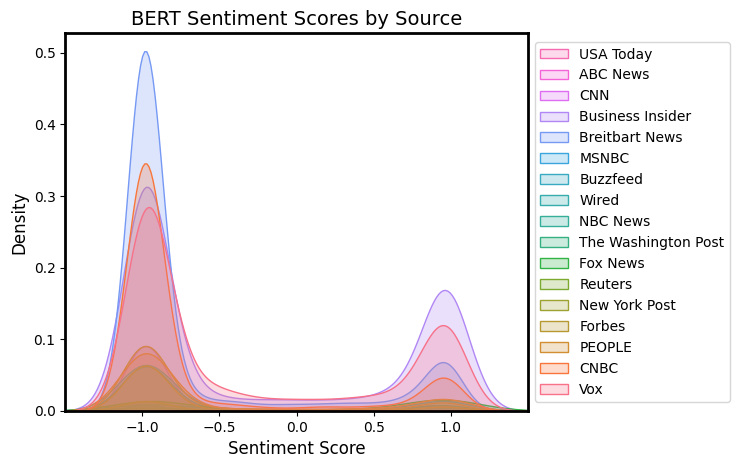

In [8]:
# Plot KDE of BERT
plt.figure(figsize=(7.5, 8.5 / (16 / 9)))
sns.kdeplot(data=news_04_df, x='sentiment_bert', hue='source_name', fill=True)

min_sentiment = news_04_df['sentiment_bert'].min()
max_sentiment = news_04_df['sentiment_bert'].max()
plt.xlim(min_sentiment - 0.5, max_sentiment + 0.5)

plt.title('BERT Sentiment Scores by Source')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend(labels=news_04_df['source_name'].unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

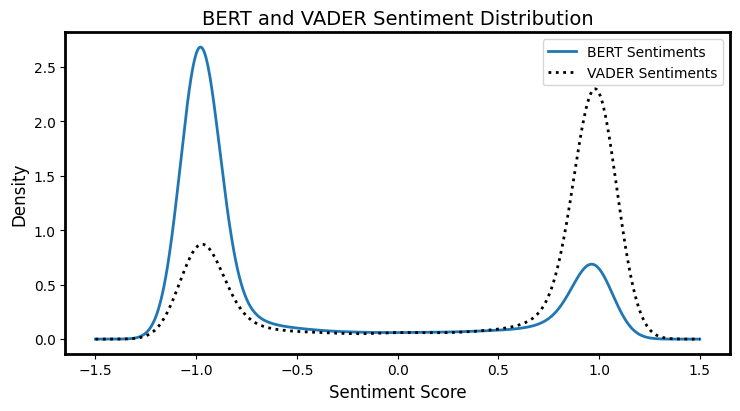

In [9]:
# Plot distribution comparison

# Compute KDE for 'sentiment_bert'
bert_kde = gaussian_kde(news_04_df['sentiment_bert'])
x_bert = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_bert = bert_kde(x_bert)
plt.plot(x_bert, y_bert, label='BERT Sentiments')

# Compute KDE for 'sentiment_vader_compound'
vadar_kde = gaussian_kde(news_04_df['sentiment_vader_compound'])
x_vadar = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_vadar = vadar_kde(x_vadar) * len(news_04_df['sentiment_bert']) / len(news_04_df['sentiment_vader_compound'])
plt.plot(x_vadar, y_vadar, linestyle='dotted', color='black', label='VADER Sentiments')

plt.title('BERT and VADER Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
news_04_df[:30][['title', 'sentiment_vader_compound', 'sentiment_bert']]

,title,sentiment_vader_compound,sentiment_bert
0,"Tito's launches 'Tito's in a Big Can,' an empty cocktail keg listed at $200",0.87,-0.98
1,Search for missing actor Julian Sands continues in 'limited capacity',0.98,0.96
2,Four star running back picks Michigan State over UNC,0.99,-0.97
3,Alabama center Charles Bediako signs one-year deal with San Antonio Spurs,0.98,0.99
4,Ralph Sampson breaks down iconic Boston Celtics-Houston Rockets fight in 1986 playoffs,0.67,0.82
5,Cowherd: Lakers are delusional for wanting to pay Austin Reaves big bucks,0.99,-0.09
6,Recruiting Roundup: Latest Alabama Football recruiting news,1.00,-0.97
7,Eagles’ 2023 training camp preview: Jalen Hurts joins an elite tier of NFL quarterbacks,0.59,-0.38
8,Lincoln Riley’s late-night emoji tweets equal four USC commits on Tuesday,0.92,-0.99
9,Washington passes California as most expensive state for gas: AAA,0.23,-1.00


## Sentiment Modeling on Labeled Dataset (experimental)

In [11]:
# Select models to run against pre-labeled data
models = [
    {'name': 'DistilBERT', 'col_suffix': 'distilbert', 'hf_model': 'distilbert-base-uncased-finetuned-sst-2-english'},
    # https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
    # NEGATIVE, POSITIVE

    {'name': 'BERT (base)', 'col_suffix': 'bert', 'hf_model': 'bert-base-uncased'},
    # https://huggingface.co/bert-base-uncased
    # LABEL_0, LABEL_1

    {'name': 'RoBERTa', 'col_suffix': 'roberta', 'hf_model': 'siebert/sentiment-roberta-large-english'},
    # https://huggingface.co/siebert/sentiment-roberta-large-english
    # NEGATIVE, POSITIVE

    {'name': 'RoBERTa (multi)', 'col_suffix': 'roberta_m', 'hf_model': 'cardiffnlp/twitter-roberta-base-sentiment'}
    # https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
    # LABEL_0, LABEL_1, LABEL_2
]

In [12]:
# Set base random seeds to ensure result consistency
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)

In [13]:
# Pre-trained SA model execution
def run_model(hf_model, df, column, device):
    print('Processing', hf_model)

    start = time.time()

    # Initialize huggingface tokenizer (auto)
    tokenizer = transformers.AutoTokenizer.from_pretrained(hf_model)
    tokenizer.pad_token = '[PAD]'

    # Run sentiment analysis using huggingface's pipeline() capability (nice!)
    classifier = transformers.pipeline('sentiment-analysis', model=hf_model, tokenizer=tokenizer, device=device)

    # Extract results
    results = [classifier(doc, truncation=True, padding='max_length', max_length=512)
               for doc in tqdm(df[column].tolist(), leave=True)]

    # Convert sentiment labels for consistency
    unique_labels = set(result[0]['label'] for result in results)
    if "LABEL_2" in unique_labels:
        labels = ['negative' if result[0]['label'] == 'LABEL_0'
                  else 'neutral' if result[0]['label'] == 'LABEL_1'
                  else 'positive' for result in results]
    elif "LABEL_1" in unique_labels:
        labels = ['negative' if result[0]['label'] == 'LABEL_0'
                  else 'positive' for result in results]
    else:
        labels = [result[0]['label'] for result in results]
    labels = [label.lower() for label in labels]

    scores = [result[0]['score'] for result in results]

    elapsed = time.time() - start
    return labels, scores, elapsed

In [14]:
# Set dataframe copy for SA model runs
train_01_df = train_00_df.copy()

# Initialize dataframe for capturing comparitive results
results_df = pd.DataFrame()

# Convert pre-labels to lower-case for comparison
train_01_df['TRUE_SENTIMENT'] = train_01_df['TRUE_SENTIMENT'].str.lower()

# Avoid "noise" in model runs
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()

# Iterate through selected models and compile results for comparison
for i, model in enumerate(models):
    # Run model
    labels, scores, elapsed = run_model(model['hf_model'], train_01_df, 'DOCUMENT', device)

    # Perist scores and labels
    train_01_df['sentiment_' + model['col_suffix']] = scores

    m = 'sentiment_' + model['col_suffix'] + '_cat'
    train_01_df[m] = labels

    # Was it multi-class (i.e., includes "neutral"), inherent to some models?
    multi = ('neutral' in train_01_df[m].unique())

    # . . . if so, keep, otherwise, filter out pre-labels so comparison works on 0/1
    if multi:
        filtered_df = train_01_df
    else:
        filtered_df = train_01_df[train_01_df['TRUE_SENTIMENT'] != 'neutral']

    # Show classification report along the way
    cr = metrics.classification_report(filtered_df['TRUE_SENTIMENT'], filtered_df[m], zero_division=0)
    print(cr)

    cr = metrics.classification_report(filtered_df['TRUE_SENTIMENT'], filtered_df[m], zero_division=0, output_dict=True)

    # Persist results for later comparison
    data = {
        'id': i,
        'model': model['name'],
        'hf_model': model['hf_model'],
        'multi': multi,
        'elapsed_time': elapsed,
        'accuracy': cr['accuracy'],
        'precision': cr['macro avg']['precision'],
        'recall': cr['macro avg']['recall'],
        'f1': cr['macro avg']['f1-score']
    }
    results_df = pd.concat([results_df, pd.DataFrame(data, index=[0])], ignore_index=True)

results_df = results_df.sort_values(by=['f1', 'accuracy'], ascending=False)

Processing distilbert-base-uncased-finetuned-sst-2-english


  0%|          | 1/3355 [00:03<3:08:08,  3.37s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3355/3355 [00:28<00:00, 116.28it/s]


              precision    recall  f1-score   support

    negative       0.22      0.91      0.36       351
    positive       0.95      0.37      0.54      1758

    accuracy                           0.46      2109
   macro avg       0.59      0.64      0.45      2109
weighted avg       0.83      0.46      0.51      2109

Processing bert-base-uncased


  0%|          | 7/3355 [00:00<00:51, 65.24it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3355/3355 [00:41<00:00, 80.33it/s]


              precision    recall  f1-score   support

    negative       0.17      0.99      0.29       351
    positive       0.83      0.01      0.02      1758

    accuracy                           0.17      2109
   macro avg       0.50      0.50      0.15      2109
weighted avg       0.72      0.17      0.06      2109

Processing siebert/sentiment-roberta-large-english


  0%|          | 9/3355 [00:00<02:07, 26.31it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3355/3355 [01:58<00:00, 28.21it/s]


              precision    recall  f1-score   support

    negative       0.33      0.75      0.46       351
    positive       0.93      0.70      0.80      1758

    accuracy                           0.71      2109
   macro avg       0.63      0.72      0.63      2109
weighted avg       0.83      0.71      0.74      2109

Processing cardiffnlp/twitter-roberta-base-sentiment


  0%|          | 7/3355 [00:00<00:50, 66.26it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3355/3355 [00:42<00:00, 78.70it/s]


              precision    recall  f1-score   support

    negative       0.19      0.52      0.28       351
     neutral       0.37      0.60      0.46      1246
    positive       0.79      0.16      0.26      1758

    accuracy                           0.36      3355
   macro avg       0.45      0.43      0.33      3355
weighted avg       0.57      0.36      0.33      3355



In [15]:
# Results (comparison)?
results_df

,id,model,hf_model,multi,elapsed_time,accuracy,precision,recall,f1
2,2,RoBERTa,siebert/sentiment-roberta-large-english,False,132.83,0.71,0.63,0.72,0.63
0,0,DistilBERT,distilbert-base-uncased-finetuned-sst-2-english,False,42.64,0.46,0.59,0.64,0.45
3,3,RoBERTa (multi),cardiffnlp/twitter-roberta-base-sentiment,True,50.27,0.36,0.45,0.43,0.33
1,1,BERT (base),bert-base-uncased,False,48.62,0.17,0.50,0.50,0.15


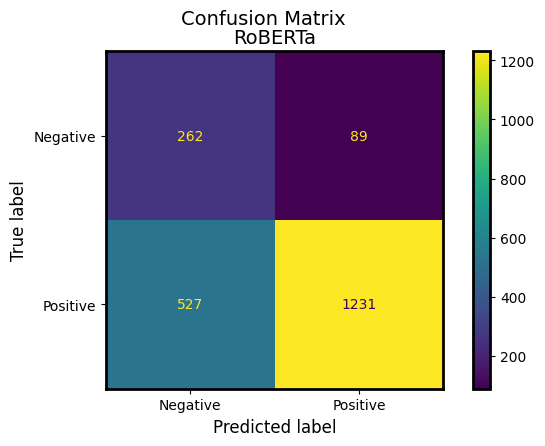

In [16]:
# Select best model for confusion matrix
best_id = 2
best_m = 'sentiment_' + models[best_id]['col_suffix'] + '_cat'

# Similar filtering to above
if 'neutral' in train_01_df[best_m].unique():
    filtered_df = train_01_df
else:
    filtered_df = train_01_df[train_01_df['TRUE_SENTIMENT'] != 'neutral']

# Get unique labels for best graphic
dlabels = np.unique(filtered_df[best_m].unique())

# Plot confusion matrix
fig, ax = plt.subplots()

cmd = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(
    filtered_df['TRUE_SENTIMENT'], filtered_df[best_m]), display_labels=[s.capitalize() for s in dlabels])
cmd.plot(ax = ax)

plt.suptitle('Confusion Matrix', y = 1)
plt.title(models[best_id]['name'])
plt.show()

## Sentiment Analysis: EDA Extended

In [17]:
news_05_df = news_04_df.copy()
news_05_df['processed_text'].fillna('neutral', inplace=True)

# Load pre-trained model
model_name = 'siebert/sentiment-roberta-large-english'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

# Attempt GPU usage (works on Colab; I don't have a dedicated local GPU)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get sentiment (probability and label) function
def analyze_sentiment(text):
    # Encode text; truncate if necessary (note, not chunking full article, just using first 512)
    inputs = tokenizer.encode_plus(text, truncation=True, max_length=512,
                                   padding='max_length', return_tensors='pt')

    # Move tensors to appropriate device (GPU if available)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference
    outputs = model(input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'])  # could also unpack this wth simple model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax().item()

    # Apply softmax to logits to get class probabilities
    probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()
    sentiment_score = probabilities[0][1]

    # Map predicted class to sentiment label
    sentiment_label = 'positive' if predicted_class == 1 else 'negative'

    return pd.Series([sentiment_score, sentiment_label])

# Apply sentiment analysis to 'processed_text' column
news_05_df[['sentiment_roberta_prob', 'sentiment_roberta_cat']] =\
    news_05_df['processed_text'].progress_apply(analyze_sentiment)

# Standardize BERT probability back to a sentiment score, for comparison
news_05_df['sentiment_roberta'] = 2 * (news_05_df['sentiment_roberta_prob'] - 0.5)

# Persist dataframe with sentiments (so don't need to re-run)
print(f'Writing={len(news_05_df)}')
subset_df = news_05_df[['text_id',
                        'sentiment_vader', 'sentiment_vader_compound', 'sentiment_vader_cat',
                        'sentiment_bert_prob', 'sentiment_bert_cat', 'sentiment_bert',
                        'sentiment_roberta_prob', 'sentiment_roberta_cat', 'sentiment_roberta']]
subset_df.to_csv('../data/news-05.csv', index=False)
print(f'Written={len(subset_df)}')

# Summarize sentiment by 'source_name' for analysis by source
grouped_sentiment = news_05_df.groupby('source_name')['sentiment_roberta_cat'].value_counts()
print(grouped_sentiment.to_string(max_rows=None))

100%|██████████| 36405/36405 [23:22<00:00, 25.96it/s]


Writing=36405
Written=36405
source_name          sentiment_roberta_cat
ABC News             positive                 2707
                     negative                 2151
Breitbart News       negative                  536
                     positive                  502
Business Insider     positive                 1021
                     negative                  542
Buzzfeed             positive                  691
                     negative                   59
CNBC                 positive                  955
                     negative                  383
CNN                  positive                 1059
                     negative                  627
Forbes               positive                 6506
                     negative                 1280
Fox News             positive                  783
                     negative                  596
MSNBC                negative                  140
                     positive                   85
NBC News   